In [1]:
import math
import copy
import numpy as np
import pandas as pd
import random as rd
import networkx as nx
from tqdm import tqdm
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection

import warnings
warnings.filterwarnings("ignore")

In [2]:
def expected_degree_graph(w,
                          selfloops:bool = True):
    
    """
    Expected degree graph generator taken from NX and changed for the directed graph

    Inputs:
    ------------------------
    w : list
        The list of expected degrees.
    selfloops : bool = True
        Set to False to remove the possibility of self-loop edges.
    
    Returns:
    ------------------------
    Graph
    """

    rd.seed(2023)

    n = len(w)
    G = nx.DiGraph()

    # If there are no nodes are no edges in the graph, return the empty graph.
    if n == 0 or max(w) == 0:
        return G

    rho = 1 / sum(w)
    # Sort the weights in decreasing order. The original order of the
    # weights dictates the order of the (integer) node labels, so we
    # need to remember the permutation applied in the sorting.
    order = sorted(enumerate(w), key = itemgetter(1), reverse = True)
    mapping = {c: u for c, (u, v) in enumerate(order)}
    seq = [v for u, v in order]
    last = n
    if not selfloops:
        last -= 1
    for u in range(last):
        v = u
        if not selfloops:
            v += 1
        factor = seq[u] * rho
        p = min(seq[v] * factor, 1)
        while v < n and p > 0:
            if p != 1:
                r = rd.random()
                v += math.floor(math.log(r, 1 - p))
            if v < n:
                q = min(seq[v] * factor, 1)
                if rd.random() < q / p:
                    G.add_edge(mapping[u], mapping[v])
                v += 1
                p = q
    return G

#-------------------------------------------------------------------------------------

def graph_generation(number_of_nodes:int,
                     core_rules:str,
                     CL_average:int = None,
                     number_of_cores:int = 1,
                     plot:bool = False):

    '''
    Function for the generation of Chung-Lu directed graph

    Inputs:
    ------------------------
    number_of_nodes : int
        Number of nodes in the graph
    core_rules : str
        Rules for core list generation: ['rnd_largest', 'rnd_smallest']
    CL_average : int
        Average degree of the node
    number_of_cores:int = 1
        Number of core nodes in the graph that can't be connected

    Returns:
    ------------------------
    G
        Graph
    cores : list
        List of core nodes that can't be connected
    '''

    # Model's Parameters: Generate a random Chung-Lu graph with average degree d, max degree m, and power-law degree distribution with exponent gamma
    # Source: https://github.com/ftudisco/scalefreechunglu/blob/master/python/example.py
    gamma = 2.2
    m = number_of_nodes ** 0.5
    d = CL_average
    p = 1/(gamma-1)
    c = (1-p)*d*(number_of_nodes**p)
    i0 = (c/m)**(1/p) - 1
    w = [c/((i+i0)**p) for i in range(number_of_nodes)]
    G = expected_degree_graph(w, 1)
    
    # Get largest (in terms of number of edges) nodes and set them as cores
    stats = dict(G.out_degree())
    if core_rules == 'rnd_largest':
        potential_cores = sorted(stats, key = stats.get, reverse = True)[:number_of_cores * 5]
    elif core_rules == 'rnd_smallest':
        potential_cores = sorted(stats, key = stats.get, reverse = True)[round(0.5 * len(stats)) : round(0.7 * len(stats))]
    cores = rd.sample(potential_cores, number_of_cores)

    # Remove edges between different core nodes
    for node in cores:
        for neig in copy.deepcopy(G.neighbors(node)):
            if (neig != node) & (neig in cores):
                G.remove_edge(node, neig)
    
    print(G.size())

    # Optional part for the plotting of the graph
    if plot:
        print(stats)
        color_map = []
        for node in G.nodes():
            if node in cores:
                color_map.append('red')
            else:
                color_map.append('blue')
        nx.draw(G, node_color = color_map, with_labels = True)

    return G, cores

#-------------------------------------------------------------------------------------

def grain_generator(number_of_days:int,
                    cores:list, 
                    dist:str = 'uni'):
    
    '''
    Function for generation of coordinates for new grains

    Inputs:
    ------------------------
    number_of_days : int
        Number of iterations in the models
    cores : list
        List of core nodes that can't be connected
    dist : str = 'uni
        Distribution of the number of new grains in the model ('uni', 'expon', 'par')

    Returns:
    ------------------------
    new_grains : list
        List with coordinates of the new grains in th model
    '''

    rd.seed(2023)
    new_grains = []

    if dist == 'uni':
        for d in range(number_of_days):
            grain = rd.choice(cores)
            new_grains.append([grain])
    elif dist == 'exp':
        num_of_grains = np.around(np.random.exponential(size = number_of_days))
        for d in range(number_of_days):
            grains = []
            for g in range(int(num_of_grains[d]) + 1):
                grain = rd.choice(cores)
                grains.append(grain)
            new_grains.append(grains)
    elif dist == 'par':
        num_of_grains = np.around(np.random.pareto(a = 2, size = number_of_days))
        for d in range(number_of_days):
            grains = []
            for g in range(int(num_of_grains[d]) + 1):
                grain = rd.choice(cores)
                grains.append(grain)
            new_grains.append(grains)
    else:
        print('Check available distributions.')

    return new_grains

#-------------------------------------------------------------------------------------

def counter(G, 
            new_grains):
  
    '''
    Function for calculation of number of sand grains in and out of the model

    Inputs:
    ------------------------
    G
        Graph
    new_grains : list
        List with the coordinates of new grains

    Returns:
    ------------------------
    inner : int
        Number of grains inside the model
    outer : int
        Number of grains that have dissipated from the model
    '''

    inner = []
    outer = []
    d = 0

    final_status = pd.DataFrame.from_dict(dict(G.nodes(data = True)), orient = 'index')
    for column in final_status:
        d += 1
        total_d = 0
        inner.append(np.sum(final_status[column]))
        for i in range(d):
            total_d += len(new_grains[i])
        outer.append(total_d - np.sum(final_status[column]))

    return inner, outer

#-------------------------------------------------------------------------------------

def MA(G, 
       ones:list, 
       falls_d:int,
       passes_d:int,
       d:int, 
       node, 
       crit:int):

    '''
    Function for the modelling of the Manna sandpile
    
    Inputs:
    ------------------------
    G
        Graph
    ones : list
        List of the nodes that have no outgoing edge
    falls_d : int
        Number of the falls for the current day
    passes_d : int
        Number of the edges passed for the current day
    d : int
        Number of the iteration
    node
        Information about node from the graph
    crit : int
        Critical value that limits the level of stability of the node

    Returns:
    ------------------------
    G
        Updated graph
    falls_d : int
        Updated number of the falls for the current day
    '''
    
    rd.seed(0)
    falls_d += 1
    if node[0] not in ones:
        neighbors = [n for n in G.neighbors(node[0])]
        remains = copy.copy(crit)
        for neighbor in G.nodes(data=True):
            if neighbor[0] in neighbors:
                n = rd.randint(0, remains)
                if n > 0:
                    passes_d += 1
                remains -= n
                neighbor[1]['ill' + str(d + 1)] += n
    node[1]['ill' + str(d + 1)] -= crit

    return G, falls_d, passes_d

#-------------------------------------------------------------------------------------

def MA_fa(G, 
          facilit_list:list, 
          ones:list, 
          falls_d:int,
          passes_d:int,
          d:int, 
          node, 
          crit:int):
    
    '''
    Function for the modelling of the facilitated Manna sandpile
    
    Inputs:
    ------------------------
    G
        Graph
    facilit_list:list
        List of the number of falls to the node in the model
    ones : list
        List of the nodes that have no outgoing edge
    falls_d : int
        Number of the falls for the current day
    passes_d : int
        Number of the edges passed for the current day
    d : int
        Number of the iteration
    node
        Information about node from the graph
    crit : int
        Critical value that limits the level of stability of the node

    Returns:
    ------------------------
    G
        Updated graph
    falls_d : int
        Updated number of the falls for the current day
    '''
    
    rd.seed(0)
    falls_d += 1
    if node[0] not in ones:
        neighbors = [n for n in G.neighbors(node[0])]
        if node[1]['ill'+str(d)] >= crit:
            remains = copy.copy(crit)
            for neighbor in G.nodes(data=True):
                if neighbor[0] in neighbors:
                    n = rd.randint(0, remains)
                    if n > 0:
                        passes_d += 1
                    remains -= n
                    neighbor[1]['ill' + str(d + 1)] += n
                    if n > 0 and d + 1 <= len(facilit_list):
                        facilit_list[d + 1][neighbor[0]] += 1
            node[1]['ill' + str(d + 1)] -= crit
        elif node[1]['ill' + str(d)] < crit and node[1]['ill' + str(d)] > 0:
            remains = node[1]['ill' + str(d)]
            for neighbor in G.nodes(data = True):
                if neighbor[0] in neighbors:
                    n = rd.randint(0, remains)
                    if n > 0:
                        passes_d += 1
                    remains -= n
                    neighbor[1]['ill' + str(d + 1)] += n
                    if n > 0 and d + 1 <= len(facilit_list):
                        facilit_list[d + 1][neighbor[0]] += 1
            node[1]['ill' + str(d + 1)] -= node[1]['ill' + str(d)]
    else:
        node[1]['ill' + str(d + 1)] -= crit

    return G, facilit_list, falls_d, passes_d

#-------------------------------------------------------------------------------------

def spread(G,
           number_of_days:int,
           new_grains:list,
           number_of_nodes:int,
           directory:str,
           core_rules:str,
           number_of_cores:int = 1, 
           facilitated:bool = False):

    '''
    Function for the modelling of Manna sandpile model on the directed Chung-Lu graph

    Inputs:
    ------------------------
    G
        Graph
    number_of_days : int
        Number of iterations in the models
    new_grains : list
        List with coordinates of the new grains in th model
    number_of_nodes : int
        Number of nodes in the graph
    directory : str
        Directory for the models to be stored
    core_rules : str
        Rules for core list generation: ['rnd_largest', 'rnd_smallest']
    number_of_cores : int = 1
        Number of core nodes in the graph that can't be connected   
    facilitated : bool = False
        Flag to mark if the model is facilitated

    Returns:
    ------------------------
    File with number of falls in the model
    Graph with number of inner and dissipated grains
    Graph with number of falls in the model
    '''

    inner = []
    outer = []
    falls = []
    passes = []
    deg = pd.DataFrame(columns = ['Node', 'Degree'])

    degrees = [[node, val]  for (node, val) in G.out_degree()]
    for degree in degrees:
        deg.loc[len(deg)] =  [degree[0], degree[1]]
    ones = deg[deg['Degree'] == 0]['Node'].values
    deg.set_index('Node', inplace = True)

    status = pd.DataFrame()
    for j in range(0, number_of_days):
        status['ill' + str(j)] = np.zeros(number_of_nodes)

    node_attr = status.to_dict('index')
    nx.set_node_attributes(G, node_attr)

    if facilitated:
        facilit_list = [[0 for x in range(G.number_of_nodes())] for z in range(number_of_days)]

    for d in tqdm(range(0, number_of_days-1)):
        falls_d = 0
        passes_d = 0
        for node in G.nodes(data = True):
            if node[0] in new_grains[d]:
                node[1]['ill' + str(d)] += 1.0
            node[1]['ill' + str(d + 1)] += node[1]['ill' + str(d)]
        for node in G.nodes(data = True):
            if facilitated == False:
                if (d <= (number_of_days - 1)) & (node[1]['ill' + str(d)] >= deg['Degree'][node[0]]) & (deg['Degree'][node[0]] > 0):
                    G, falls_d, passes_d = MA(G, ones, falls_d, passes_d, d, node, deg['Degree'][node[0]])
            else:
                if (d <= (number_of_days - 1)) & (node[1]['ill' + str(d)] >= deg['Degree'][node[0]] | facilit_list[d][node[0]] >= 2) & (deg['Degree'][node[0]] > 0):
                    G, facilit_list, falls_d, passes_d = MA_fa(G, facilit_list, ones, falls_d, passes_d, d, node, deg['Degree'][node[0]])

        if d <= number_of_days - 2:
            falls.append(falls_d)
            passes.append(passes_d)
    inner, outer = counter(G, new_grains)

    graph_name = str(number_of_nodes) + '_' + str(number_of_cores) + '_' + core_rules
    if facilitated:
        graph_name += '_fa'
    data = pd.DataFrame({'falls': falls, 'passes': passes})
    data.to_csv(directory + graph_name + '.csv', index = False)

    subs = 3
    fig, axs = plt.subplots(subs, 1, figsize = (35, 30))
    for i in range(subs):
        axs[i].xaxis.get_major_locator().set_params(integer = True)
        axs[i].yaxis.get_major_locator().set_params(integer = True)
        axs[i].ticklabel_format(style = 'plain')
    axs[0].set(ylim = (0, number_of_days))
    axs[1].set(ylim = (0, 1.2 * max(falls)))
    axs[2].set(ylim = (0, 1.2 * max(passes)))
    axs[0].plot(list(range(number_of_days)), inner, color = '#40a6d1', alpha = 0.5, label = "Inner Grains")
    axs[0].plot(list(range(number_of_days)), outer, color = 'red', alpha = 0.5, label = "Outer Grains")
    axs[0].legend(loc = 'upper right', fontsize = 'medium')
    axs[0].set_title('Number of grains in and out of the ' + graph_name + ' model')
    axs[1].plot(list(range(number_of_days - 1)), falls, color = '#40a6d1', alpha = 0.5)
    axs[1].set_title('Number of falls in the ' + graph_name + ' model')
    axs[2].plot(list(range(number_of_days - 1)), passes, color = 'orange', alpha = 0.5)
    axs[2].set_title('Number of passed edges in the ' + graph_name + ' model')
    plt.setp(axs[0], xlabel = 'Iteration', ylabel = 'Grains')
    plt.setp(axs[1], xlabel = 'Iteration', ylabel = 'Falls')
    plt.setp(axs[1], xlabel = 'Iteration', ylabel = 'Passes')
    plt.tight_layout()
    plt.show()

In [3]:
# Set parametrization for the graphs
new_grains = []
number_of_days = 10000
number_of_nodes = 2500
number_of_cores = round(number_of_nodes / 25)
CL_average = 75
core_rules = 'rnd_smallest'

# Generate Chung-Lu graph
# G, cores = graph_generation(number_of_nodes, CL_average, number_of_cores)
G, cores = graph_generation(number_of_nodes, core_rules, CL_average, number_of_cores)

# Generation of the base list for coordinates of the new grains
new_grains = grain_generator(number_of_days, cores, 'exp')

25720


100%|██████████| 9999/9999 [10:13<00:00, 16.29it/s]


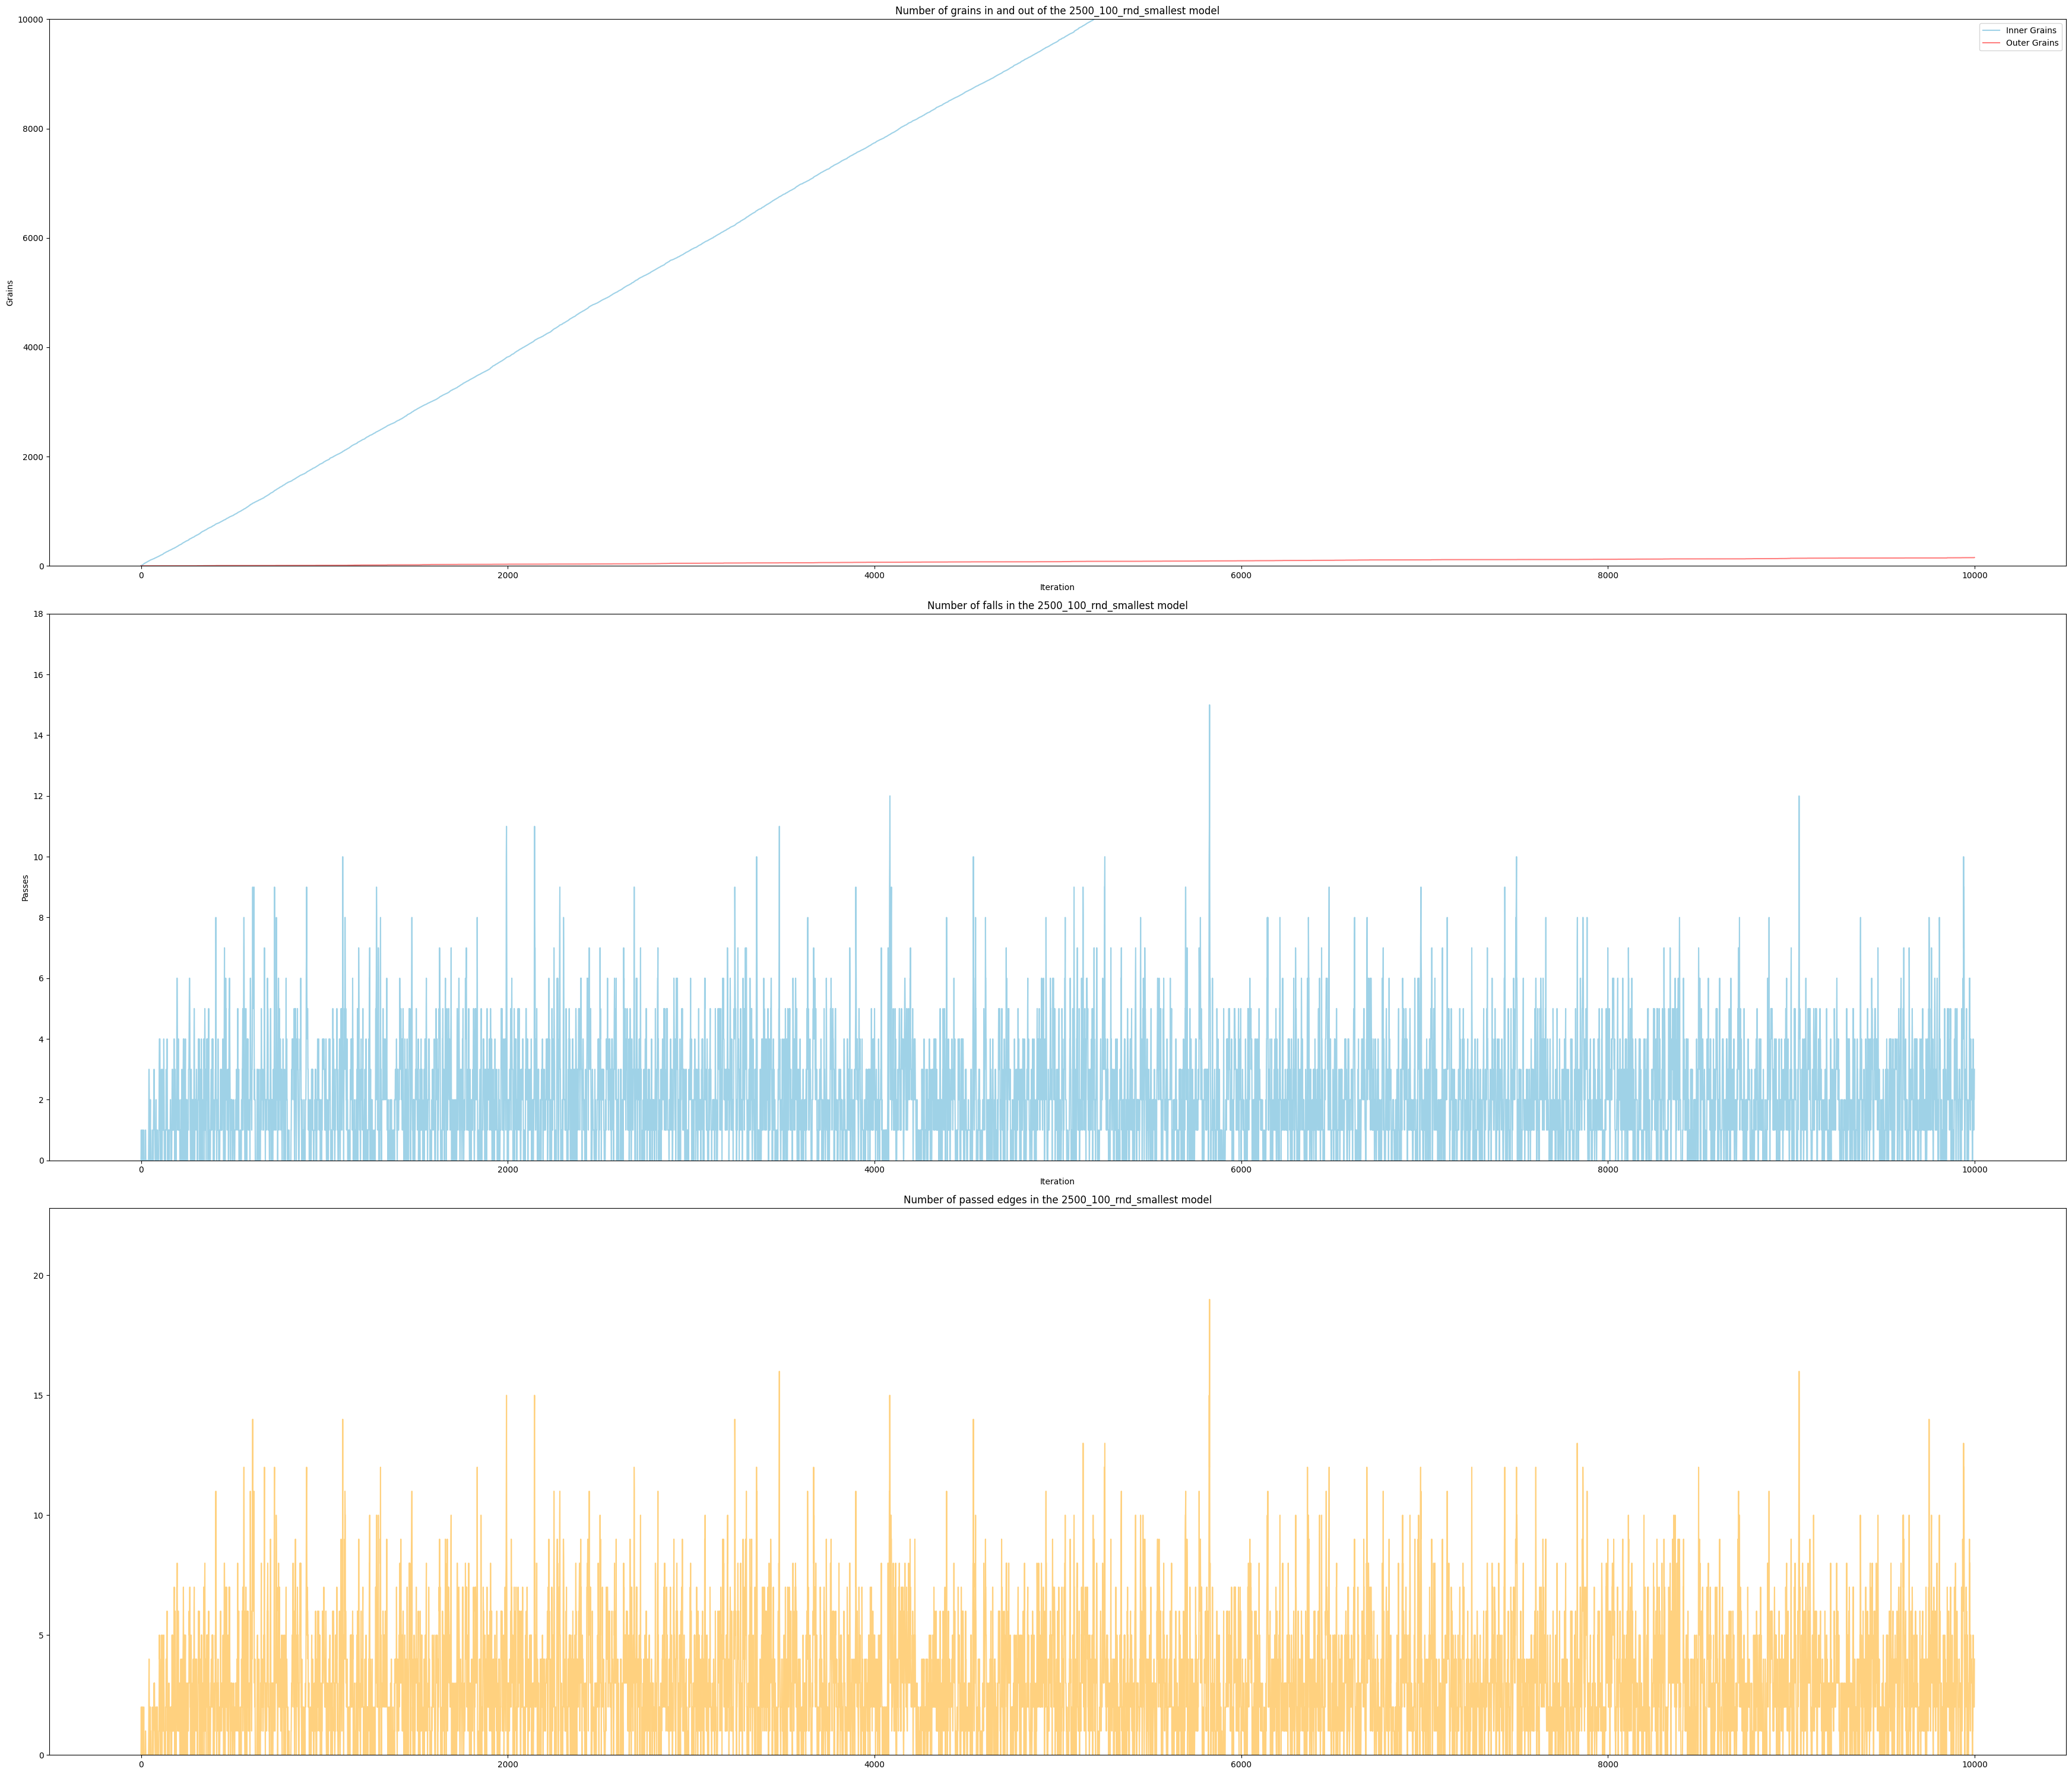

In [4]:
spread(G, number_of_days, new_grains, number_of_nodes, '...', core_rules, number_of_cores)

100%|██████████| 9999/9999 [10:26<00:00, 15.96it/s]


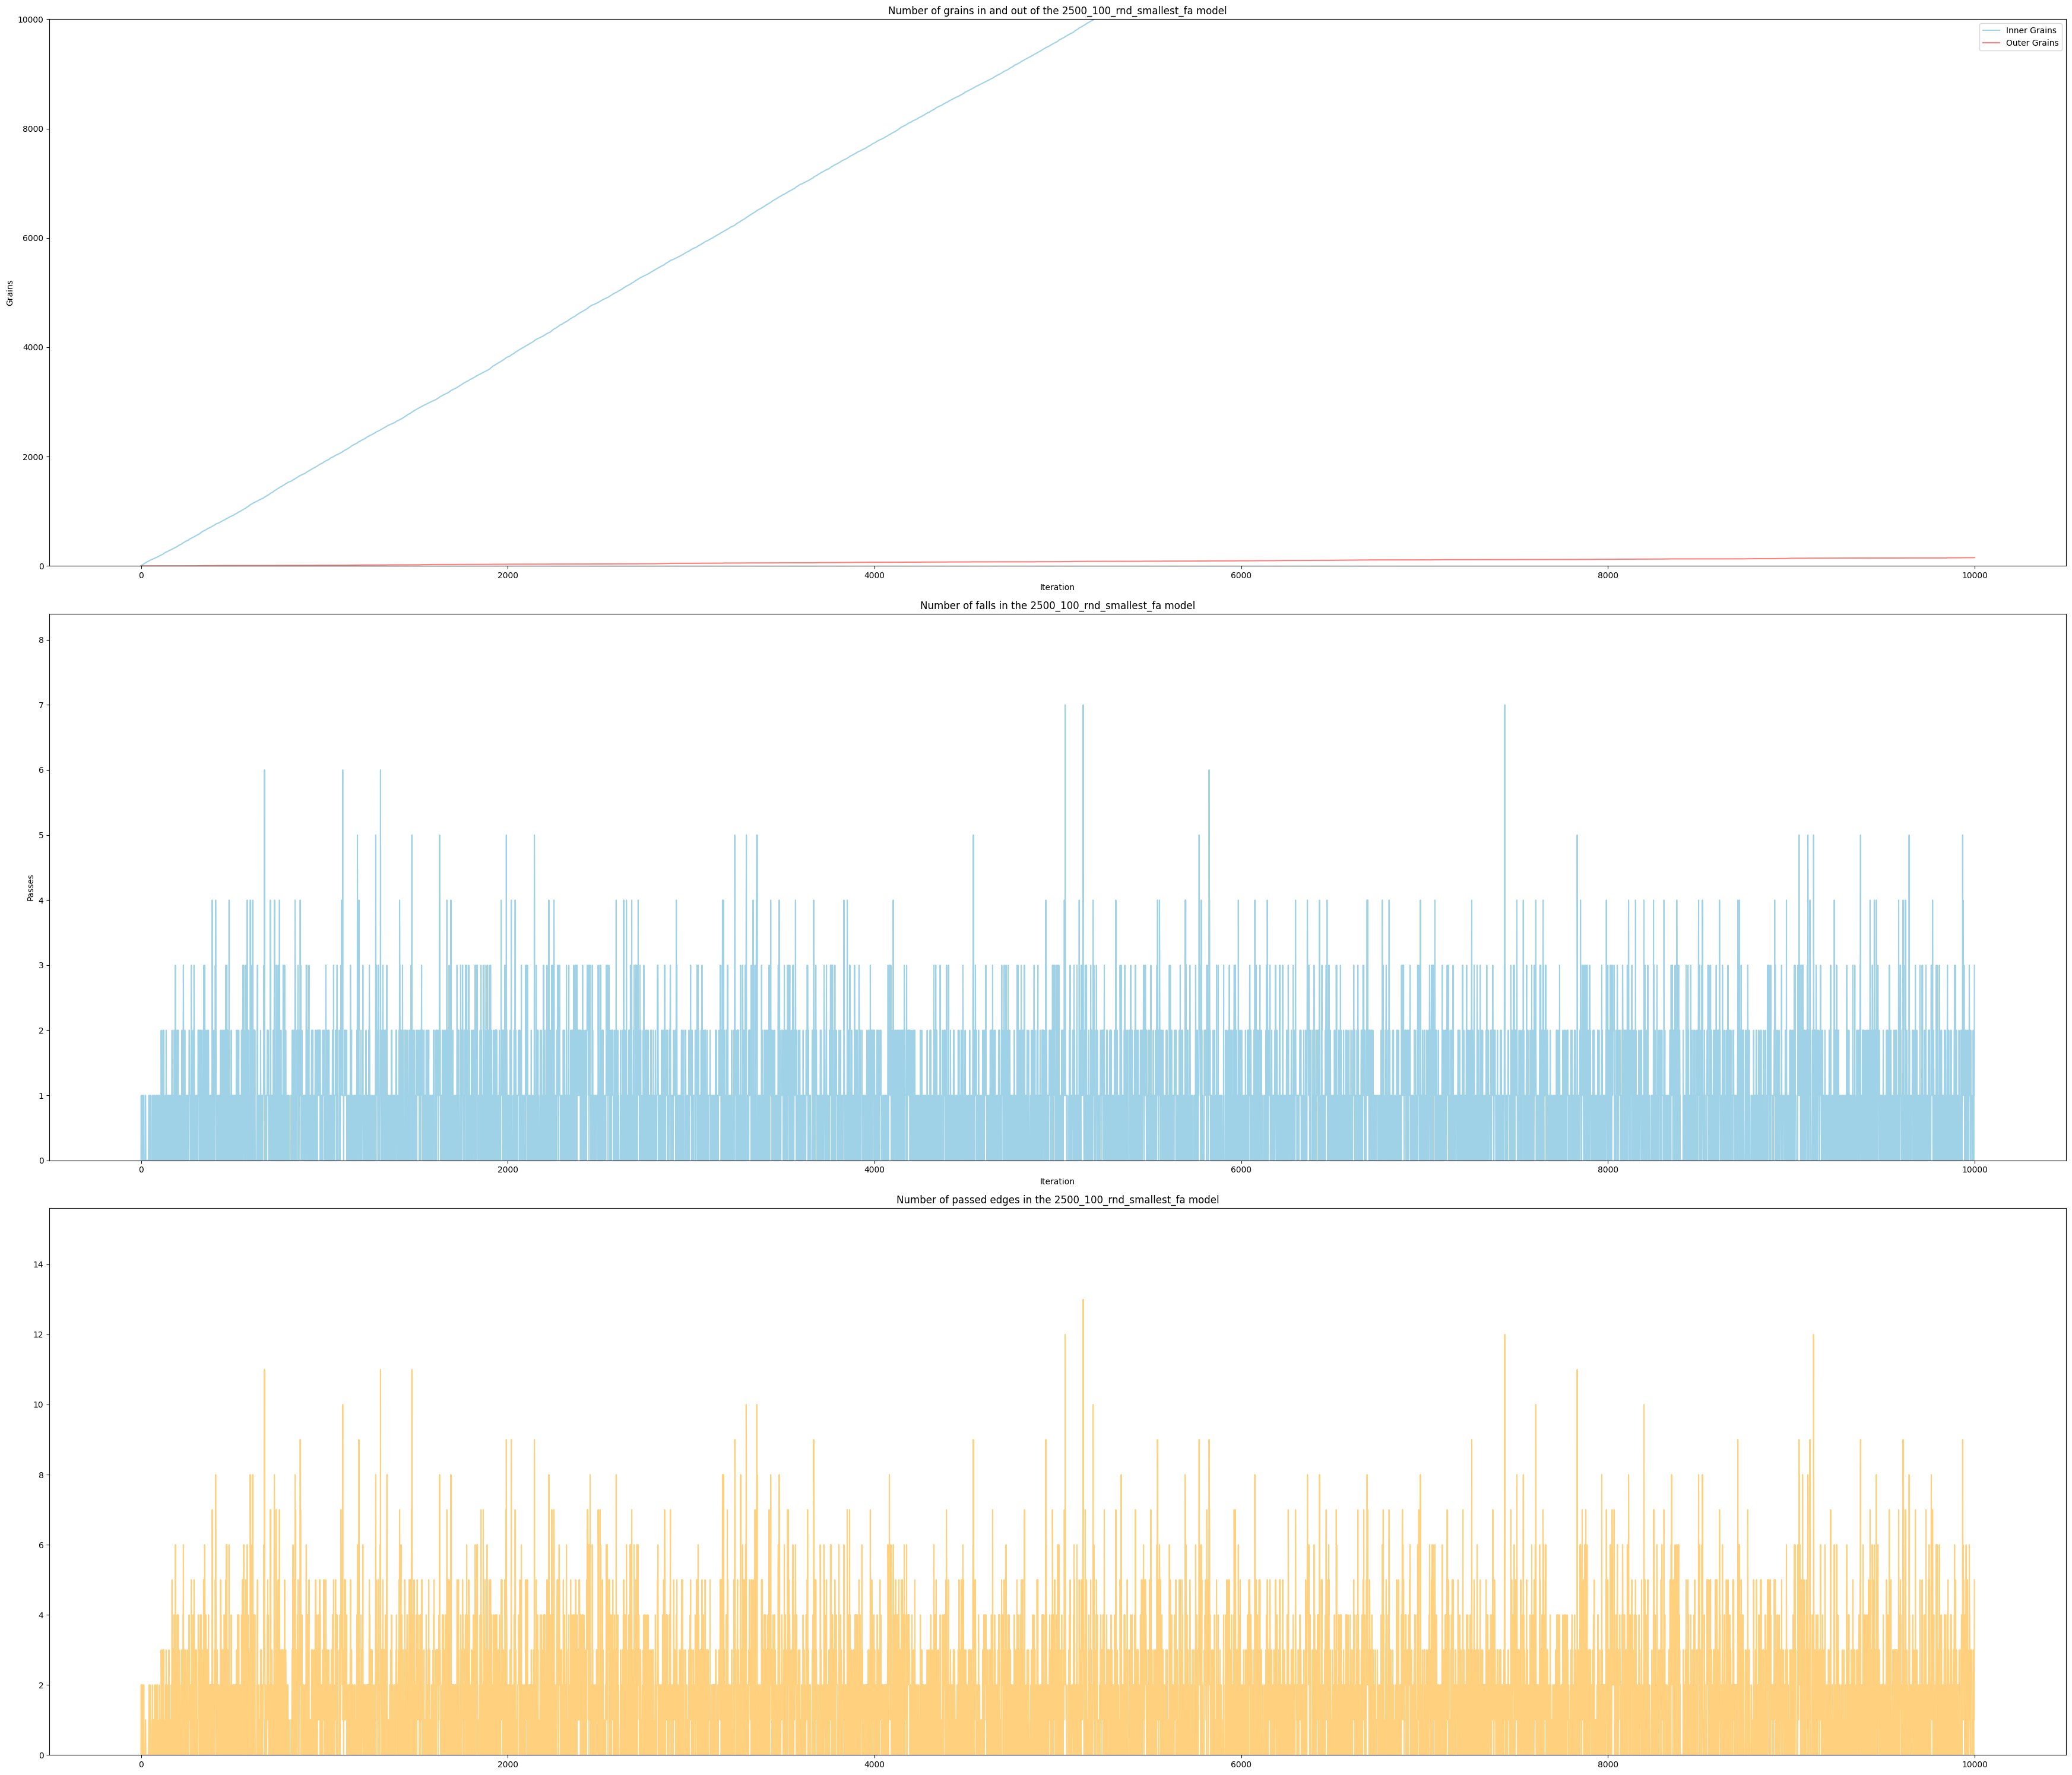

In [5]:
spread(G, number_of_days, new_grains, number_of_nodes, 'G:/My Drive/MMCC/Directed_Graph_data/', core_rules, number_of_cores, True)

25633


100%|██████████| 9999/9999 [10:35<00:00, 15.73it/s]


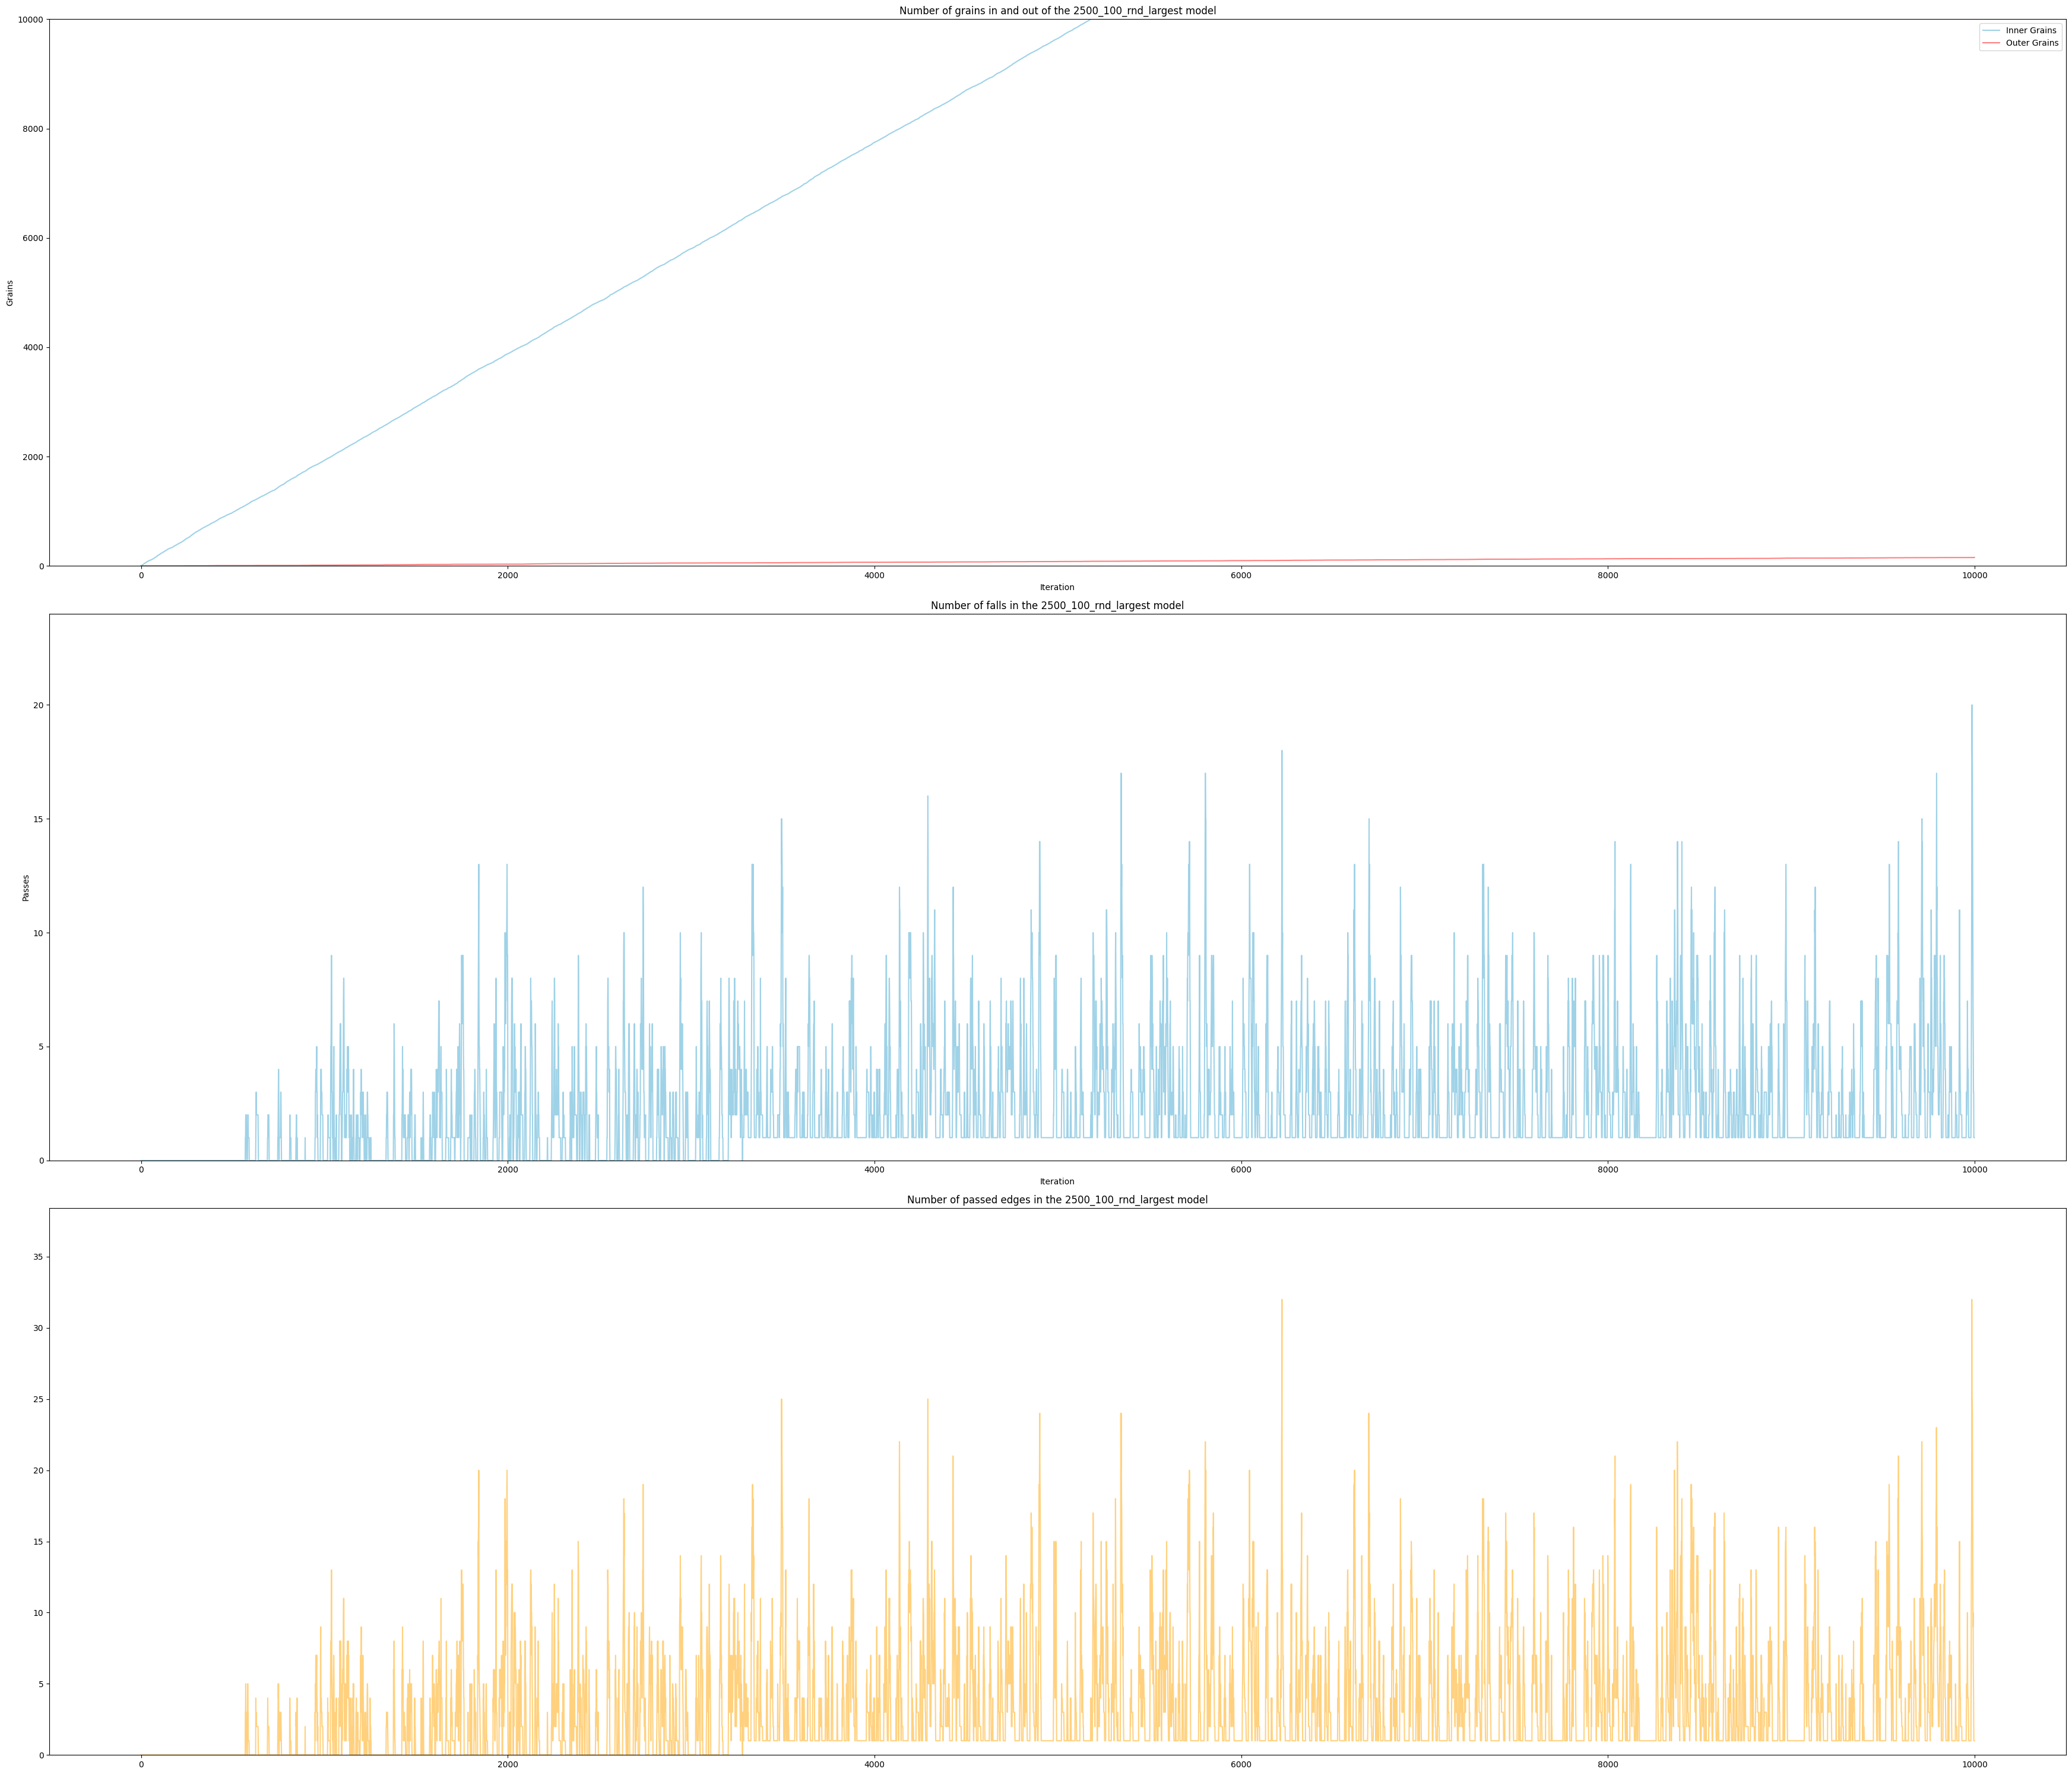

In [6]:
core_rules = 'rnd_largest'

# Generate Chung-Lu graph
# G, cores = graph_generation(number_of_nodes, CL_average, number_of_cores)
G, cores = graph_generation(number_of_nodes, core_rules, CL_average, number_of_cores)

# Generation of the base list for coordinates of the new grains
new_grains = grain_generator(number_of_days, cores, 'exp')

spread(G, number_of_days, new_grains, number_of_nodes, '...', core_rules, number_of_cores)

100%|██████████| 9999/9999 [10:31<00:00, 15.84it/s]


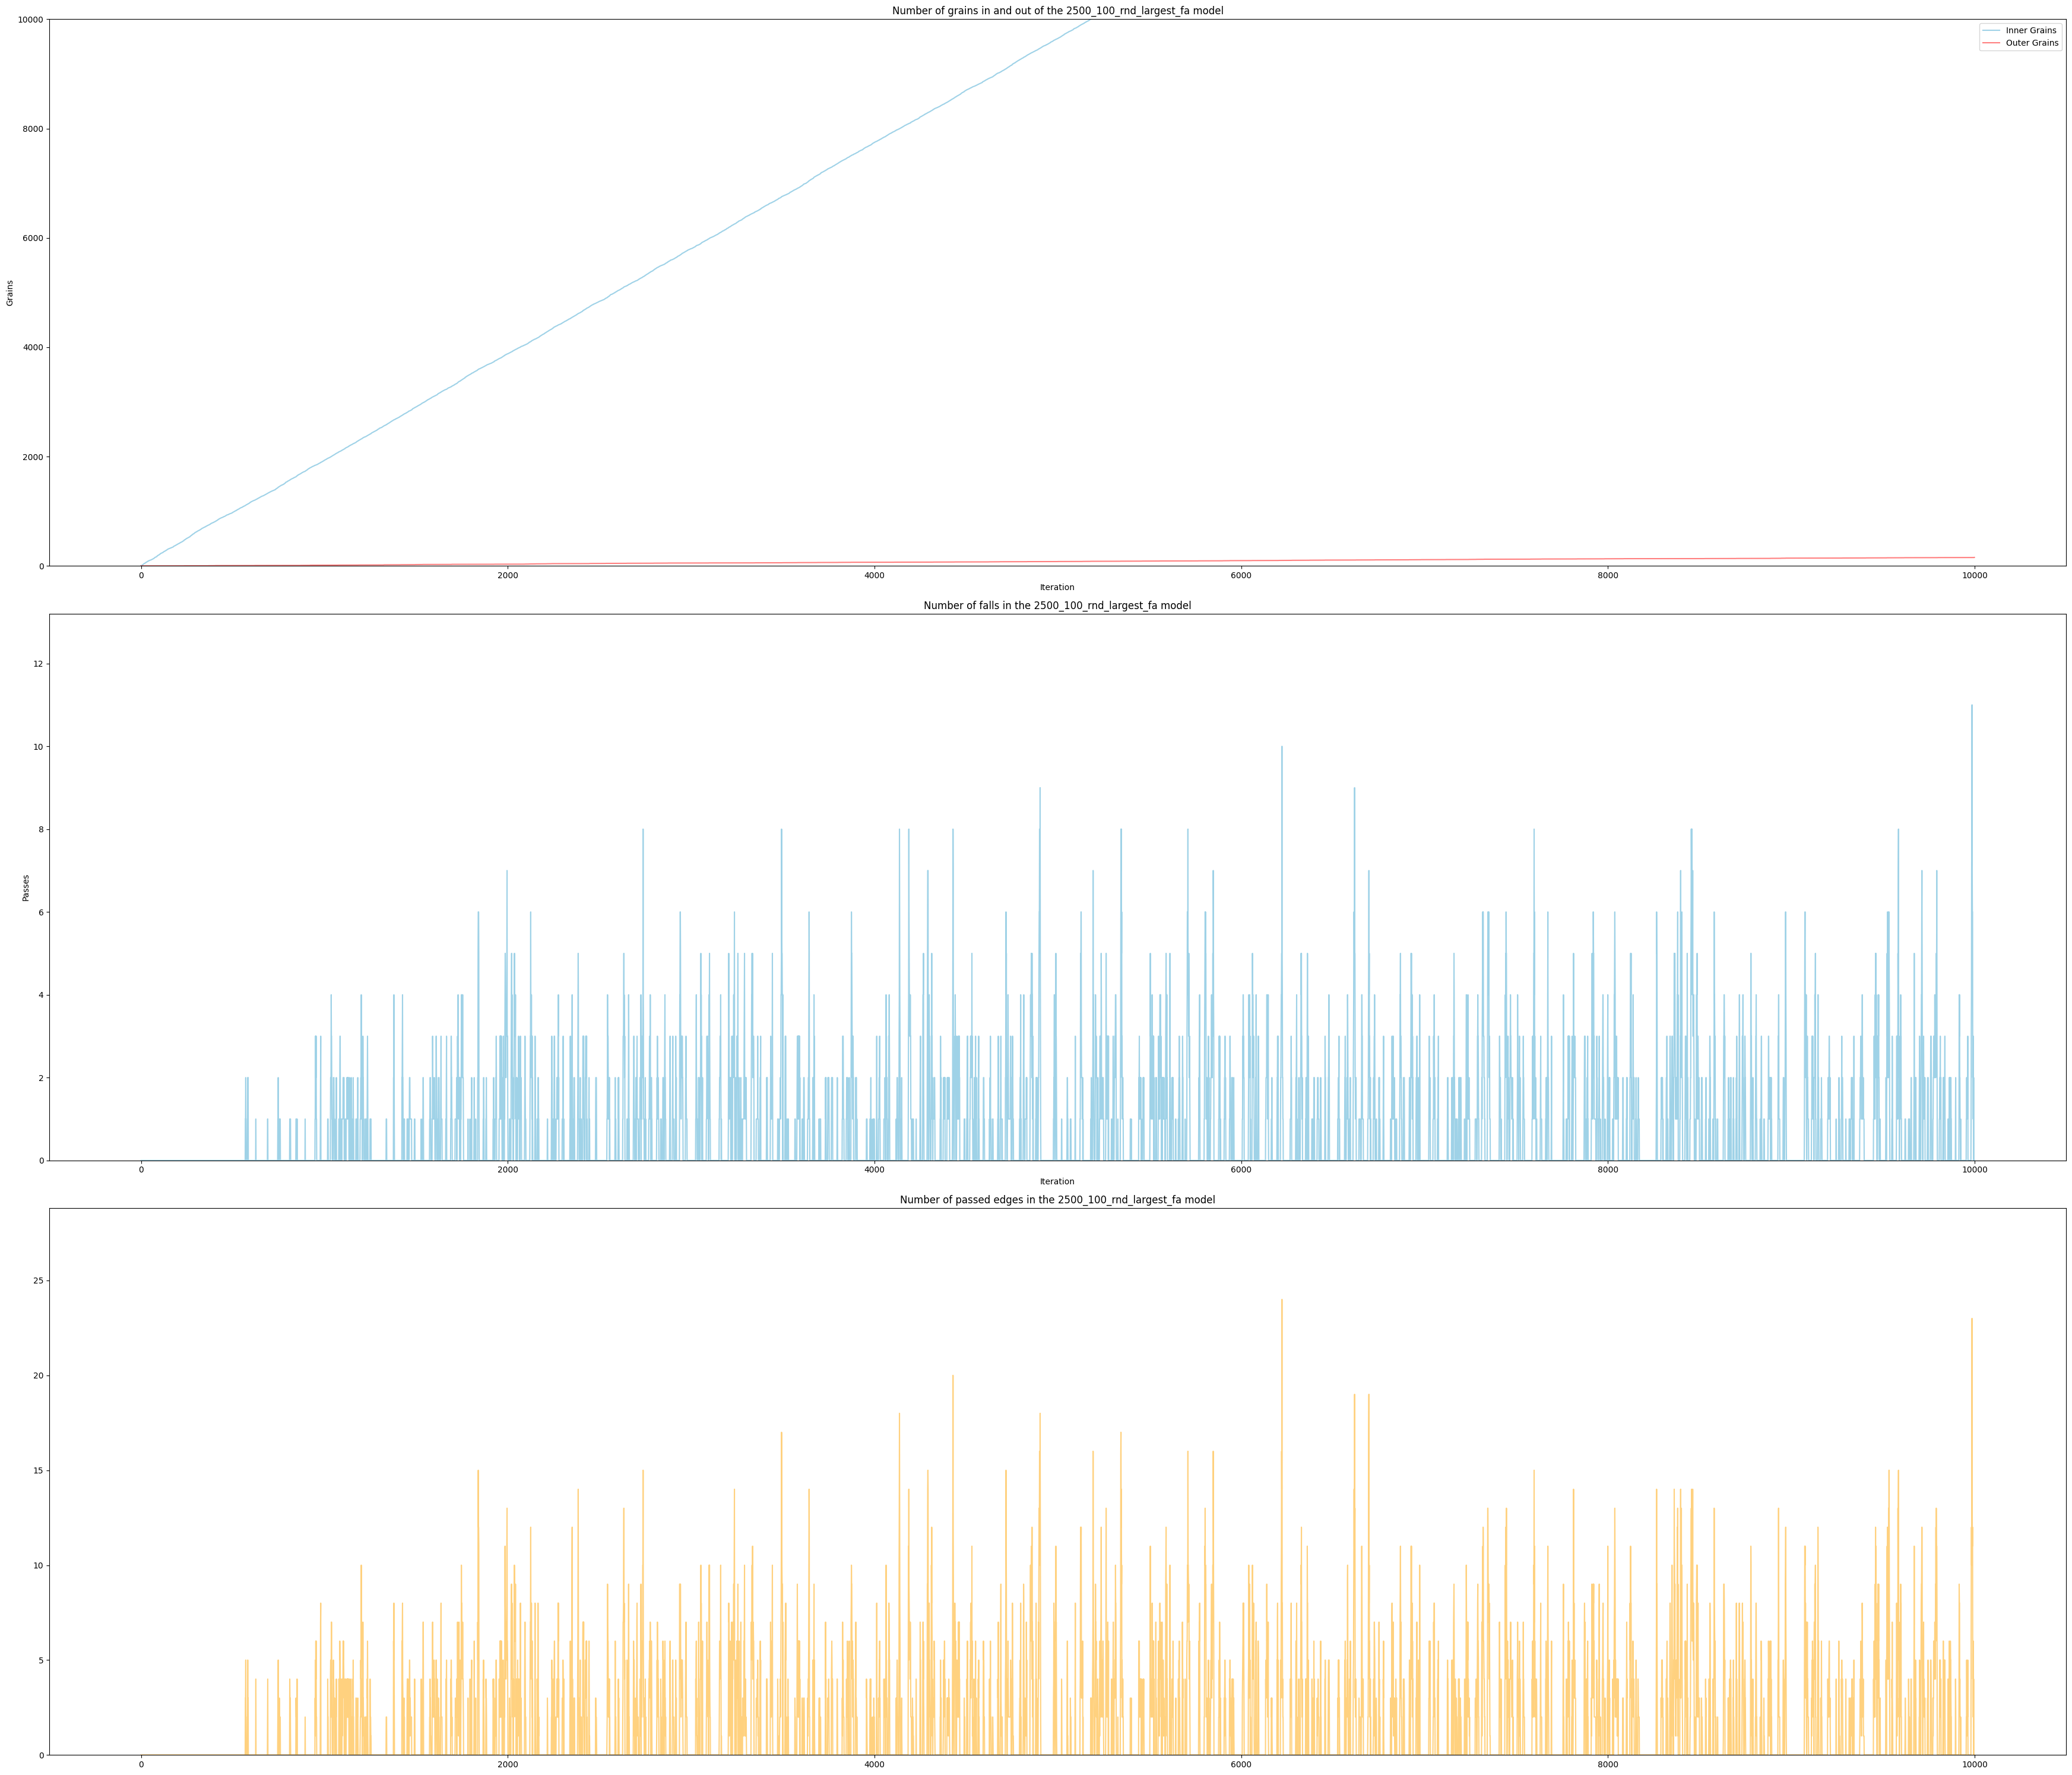

In [7]:
spread(G, number_of_days, new_grains, number_of_nodes, 'G:/My Drive/MMCC/Directed_Graph_data/', core_rules, number_of_cores, True)